# Paremeter Set

In [1]:
num_days = 365 # วันที่ต้องการทำนาย

# Predict TEMP model

In [2]:
import pycaret
import pandas as pd

In [3]:
# อ่านไฟล์ CSV
data = pd.read_csv('../export_data/filtered_data_3_best.csv')

In [4]:
# ตั้ง 'timestamp' เป็น index หากยังไม่ได้ทำ
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.set_index('timestamp', inplace=True)

# ตั้งค่า freq ให้กับ index
data = data.asfreq('D')  # 'D' สำหรับรายวัน

# แสดงแถวที่มีค่าหายไปก่อนเติม
print("แถวที่มีค่าหายไปก่อนเติม:")
print(data[data.isnull().any(axis=1)])

# เติมค่าที่หายไปด้วยการ interpolate แบบเส้นตรง
data.interpolate(method='linear', inplace=True)

# แสดงแถวที่ยังมีค่า NaN หลังจากเติม (ถ้ามี)
missing_rows_after = data[data.isnull().any(axis=1)]
if not missing_rows_after.empty:
    print("แถวที่ยังมีค่าหายไปหลังเติม:")
    print(missing_rows_after)
else:
    print("ไม่มีค่าหายไปแล้ว")


# row = data.loc["2023-09-30 07:00:00"]
# row

แถวที่มีค่าหายไปก่อนเติม:
                     humidity  pm_10  pm_2_5  pm_2_5_sp  temperature
timestamp                                                           
2023-09-30 07:00:00       NaN    NaN     NaN        NaN          NaN
ไม่มีค่าหายไปแล้ว


In [5]:
# กำหนดจำนวนวันที่ต้องการเพิ่ม
num_days = num_days

# สร้างวันที่ใหม่
next_date = data.index[-1] + pd.Timedelta(days=1)
new_dates = pd.date_range(start=next_date, periods=num_days, freq='D')

# สร้างแถวใหม่
new_rows = pd.DataFrame({'value': range(40, 40 + num_days)}, index=new_dates)

# รวมข้อมูล (ป้องกัน index ซ้ำซ้อน)
data = pd.concat([data, new_rows]).sort_index()

# ลบ index ที่ซ้ำกัน (ถ้ามี)
data = data.loc[~data.index.duplicated(keep='first')]

data.tail(10)

,humidity,pm_10,pm_2_5,pm_2_5_sp,temperature,value
2026-02-02 07:00:00,NaN,NaN,NaN,NaN,NaN,395.0
2026-02-03 07:00:00,NaN,NaN,NaN,NaN,NaN,396.0
2026-02-04 07:00:00,NaN,NaN,NaN,NaN,NaN,397.0
2026-02-05 07:00:00,NaN,NaN,NaN,NaN,NaN,398.0
2026-02-06 07:00:00,NaN,NaN,NaN,NaN,NaN,399.0
2026-02-07 07:00:00,NaN,NaN,NaN,NaN,NaN,400.0
2026-02-08 07:00:00,NaN,NaN,NaN,NaN,NaN,401.0
2026-02-09 07:00:00,NaN,NaN,NaN,NaN,NaN,402.0
2026-02-10 07:00:00,NaN,NaN,NaN,NaN,NaN,403.0
2026-02-11 07:00:00,NaN,NaN,NaN,NaN,NaN,404.0


In [6]:
last_date_temp = data.index[-1].strftime('%Y-%m-%d')

In [7]:
data = data[['temperature']]

In [8]:
data["year"] = data.index.year
data["month"] = data.index.month
data["day"] = data.index.day
data["day_of_week"] = data.index.dayofweek  # 0 = Monday, 6 = Sunday
data["week_of_year"] = data.index.isocalendar().week  # ค่าจะเป็น int64

# สมมติว่า data มี index เป็น datetime อยู่แล้ว
def assign_season(month):
    if month in [2, 3, 4]:  # ก.พ. - เม.ย.
        return "summer"        # ฤดูร้อน
    elif month in [5, 6, 7]:  # พ.ค. - ก.ค.
        return "early_rainy"   # ต้นฤดูฝน
    else:  # ส.ค. - ม.ค.
        return "late_rainy"    # ปลายฤดูฝน

season_mapping = {'summer': 0, 'early_rainy': 1, 'late_rainy': 2}
data["season"] = data.index.month.map(assign_season)
data['season'] = data['season'].map(season_mapping)

data["is_weekend"] = data.index.dayofweek.isin([5, 6]).astype(int)

import pandas as pd
import numpy as np

# สมมุติว่ามี DataFrame data ที่มีข้อมูลอยู่แล้ว
# เพิ่มฟีเจอร์ day_of_year
data['date'] = pd.to_datetime(data[['year', 'month', 'day']])
data['day_of_year'] = data['date'].dt.dayofyear

# เพิ่มฟีเจอร์ month_sin และ month_cos
data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)

# เพิ่มฟีเจอร์ day_of_week_sin และ day_of_week_cos
data['day_of_week_sin'] = np.sin(2 * np.pi * data['day_of_week'] / 7)
data['day_of_week_cos'] = np.cos(2 * np.pi * data['day_of_week'] / 7)

lag_size = 7
for i in range(1,lag_size+1):
    data[f'temperature_lag_{i}'] = data['temperature'].shift(i)


In [9]:
data.columns

Index(['temperature', 'year', 'month', 'day', 'day_of_week', 'week_of_year',
       'season', 'is_weekend', 'date', 'day_of_year', 'month_sin', 'month_cos',
       'day_of_week_sin', 'day_of_week_cos', 'temperature_lag_1',
       'temperature_lag_2', 'temperature_lag_3', 'temperature_lag_4',
       'temperature_lag_5', 'temperature_lag_6', 'temperature_lag_7'],
      dtype='object')

In [10]:
data_filtered = data.loc['2023-09':]  # ดึงข้อมูลตั้งแต่กันยายน 2023 เป็นต้นไป

In [11]:
# สมมติว่า data มีจำนวนวันทั้งหมด
total_data = len(data_filtered)

# จำนวนวันที่ต้องการเป็น test data
test_days = 30

# คำนวณสัดส่วนของ 30 วันในข้อมูลทั้งหมด
test_size = test_days / total_data

from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data_filtered, test_size=test_size, shuffle=False)



In [12]:
from pycaret.regression import load_model, predict_model

model_temp = load_model("lgmb_temp_model_eng")

Transformation Pipeline and Model Successfully Loaded


In [13]:
data_compare = data_filtered.loc[:'2025-01-12']
result = pd.DataFrame()

start_date = "2025-01-13"
end_date = last_date_temp

model = model_temp

for date in pd.date_range(start=start_date, end=end_date, freq="D"):
    # Drop columns
    test_1 = data_filtered
    # ดึงวันนี้มา
    test_1 = test_1.loc[str(date.date())]

    # ใส่เข้าไป
    data_compare = pd.concat([data_compare, test_1], axis=0)

    for i in range(1,lag_size+1):
        data_compare[f'temperature_lag_{i}'] = data_compare['temperature'].shift(i)

    # ดึง
    test_1 = (data_compare.loc[str(date.date())]).drop(columns=['temperature'])
    
    # Drop ทิ้งล่าสุดใน data_compare
    data_compare = data_compare.drop(data_compare.last_valid_index())
    test_1 = test_1[~test_1.index.duplicated(keep='last')]

    # Predict
    predict_test_1 = predict_model(model, data=test_1)

    # เพิ่มผลทำนายเข้าไปใน data_compare
    data_compare = pd.concat([data_compare, predict_test_1], axis=0)

    # แทนที่ค่าในคอลัมน์ 'pm_2_5' ในวันที่ '2025-01-13' ด้วยค่าในคอลัมน์ 'prediction_label'
    data_compare.loc[str(date.date()), 'temperature'] = data_compare.loc[str(date.date()), 'prediction_label']

    # ลบคอลัมน์ 'prediction_label' (หากต้องการแค่ผลทำนาย)
    data_compare = data_compare.drop(columns=['prediction_label'])

    # กรองเอาวันที่ซ้ำกัน (index ซ้ำ) ออกให้เหลือแค่ตัวเดียว
    data_compare = data_compare[~data_compare.index.duplicated(keep='last')]

    # บันทึกลง result
    result = pd.concat([result, predict_test_1], axis=0)

## Plot Graph TEMP

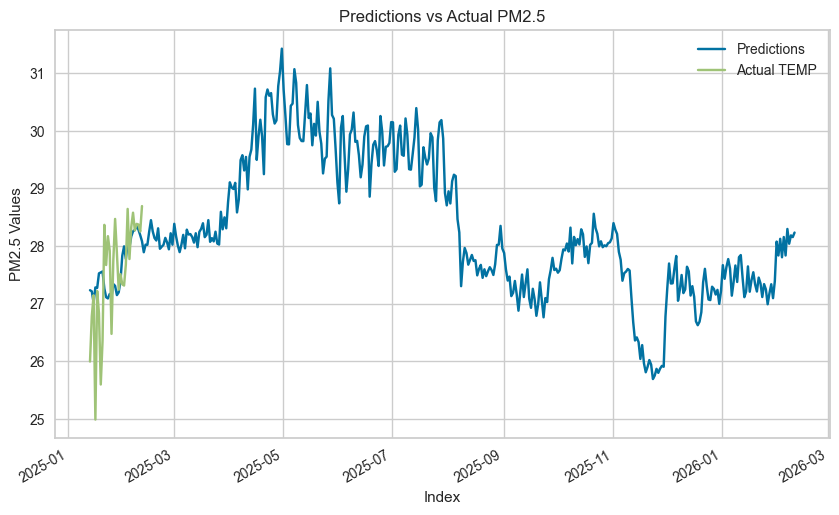

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

real_data = data_filtered.loc[start_date:end_date]
# สมมุติว่า result คือ DataFrame ที่รวม predictions กับ pm_10
result_plot = pd.concat([result['prediction_label'].shift(-1), real_data['temperature']], axis=1)
result_plot.columns = ['Predictions', 'Actual TEMP']  # ตั้งชื่อคอลัมน์

# พล็อตข้อมูล
result_plot.plot(figsize=(10, 6))

# ตั้งชื่อกราฟ
plt.title('Predictions vs Actual PM2.5')
plt.xlabel('Index')
plt.ylabel('PM2.5 Values')

# แสดงกราฟ
plt.show()

# Predict HUMI model

In [15]:
model_humi = load_model("humi_use_temp_model_2")

Transformation Pipeline and Model Successfully Loaded


In [16]:
# อ่านไฟล์ CSV
data_humi = pd.read_csv('../export_data/filtered_data_3_best.csv')

# ลบแถวล่าสุด (แถวสุดท้าย)
data_humi = data_humi.drop(data_humi.index[-1])

In [17]:
# ตั้ง 'timestamp' เป็น index หากยังไม่ได้ทำ
data_humi['timestamp'] = pd.to_datetime(data_humi['timestamp'])
data_humi.set_index('timestamp', inplace=True)

# ตั้งค่า freq ให้กับ index
data_humi = data_humi.asfreq('D')  # 'D' สำหรับรายวัน

# แสดงแถวที่มีค่าหายไปก่อนเติม
print("แถวที่มีค่าหายไปก่อนเติม:")
print(data_humi[data_humi.isnull().any(axis=1)])

# เติมค่าที่หายไปด้วยการ interpolate แบบเส้นตรง
data_humi.interpolate(method='linear', inplace=True)

# แสดงแถวที่ยังมีค่า NaN หลังจากเติม (ถ้ามี)
missing_rows_after = data_humi[data_humi.isnull().any(axis=1)]
if not missing_rows_after.empty:
    print("แถวที่ยังมีค่าหายไปหลังเติม:")
    print(missing_rows_after)
else:
    print("ไม่มีค่าหายไปแล้ว")


# row = data_humi.loc["2023-09-30 07:00:00"]
# row

แถวที่มีค่าหายไปก่อนเติม:
                     humidity  pm_10  pm_2_5  pm_2_5_sp  temperature
timestamp                                                           
2023-09-30 07:00:00       NaN    NaN     NaN        NaN          NaN
ไม่มีค่าหายไปแล้ว


In [18]:
# กำหนดจำนวนวันที่ต้องการเพิ่ม
num_days = num_days

# สร้างวันที่ใหม่
next_date = data_humi.index[-1] + pd.Timedelta(days=1)
new_dates = pd.date_range(start=next_date, periods=num_days, freq='D')

# สร้างแถวใหม่
new_rows = pd.DataFrame({'value': range(40, 40 + num_days)}, index=new_dates)

# รวมข้อมูล (ป้องกัน index ซ้ำซ้อน)
data_humi = pd.concat([data_humi, new_rows]).sort_index()

# ลบ index ที่ซ้ำกัน (ถ้ามี)
data_humi = data_humi.loc[~data_humi.index.duplicated(keep='first')]

data_humi.tail(10)

,humidity,pm_10,pm_2_5,pm_2_5_sp,temperature,value
2026-02-01 07:00:00,NaN,NaN,NaN,NaN,NaN,395.0
2026-02-02 07:00:00,NaN,NaN,NaN,NaN,NaN,396.0
2026-02-03 07:00:00,NaN,NaN,NaN,NaN,NaN,397.0
2026-02-04 07:00:00,NaN,NaN,NaN,NaN,NaN,398.0
2026-02-05 07:00:00,NaN,NaN,NaN,NaN,NaN,399.0
2026-02-06 07:00:00,NaN,NaN,NaN,NaN,NaN,400.0
2026-02-07 07:00:00,NaN,NaN,NaN,NaN,NaN,401.0
2026-02-08 07:00:00,NaN,NaN,NaN,NaN,NaN,402.0
2026-02-09 07:00:00,NaN,NaN,NaN,NaN,NaN,403.0
2026-02-10 07:00:00,NaN,NaN,NaN,NaN,NaN,404.0


In [19]:
last_date_humi = data_humi.index[-1].strftime('%Y-%m-%d')

In [20]:
# add temp predict column
shifted_predictions_temp = result['prediction_label'].shift(-1).iloc[:-1]

data_humi.loc[shifted_predictions_temp.index, 'temperature'] = shifted_predictions_temp
data_humi.tail(10)

,humidity,pm_10,pm_2_5,pm_2_5_sp,temperature,value
2026-02-01 07:00:00,NaN,NaN,NaN,NaN,27.836888,395.0
2026-02-02 07:00:00,NaN,NaN,NaN,NaN,28.125906,396.0
2026-02-03 07:00:00,NaN,NaN,NaN,NaN,27.805620,397.0
2026-02-04 07:00:00,NaN,NaN,NaN,NaN,28.157257,398.0
2026-02-05 07:00:00,NaN,NaN,NaN,NaN,27.836527,399.0
2026-02-06 07:00:00,NaN,NaN,NaN,NaN,28.296993,400.0
2026-02-07 07:00:00,NaN,NaN,NaN,NaN,28.040734,401.0
2026-02-08 07:00:00,NaN,NaN,NaN,NaN,28.185290,402.0
2026-02-09 07:00:00,NaN,NaN,NaN,NaN,28.156182,403.0
2026-02-10 07:00:00,NaN,NaN,NaN,NaN,28.234354,404.0


In [21]:
data_humi = data_humi[['humidity','temperature']]

In [22]:
data_humi["year"] = data_humi.index.year
data_humi["month"] = data_humi.index.month
data_humi["day"] = data_humi.index.day
data_humi["day_of_week"] = data_humi.index.dayofweek  # 0 = Monday, 6 = Sunday
data_humi["week_of_year"] = data_humi.index.isocalendar().week  # ค่าจะเป็น int64

# สมมติว่า data_humi มี index เป็น datetime อยู่แล้ว
def assign_season(month):
    if month in [2, 3, 4]:  # ก.พ. - เม.ย.
        return "summer"        # ฤดูร้อน
    elif month in [5, 6, 7]:  # พ.ค. - ก.ค.
        return "early_rainy"   # ต้นฤดูฝน
    else:  # ส.ค. - ม.ค.
        return "late_rainy"    # ปลายฤดูฝน

season_mapping = {'summer': 0, 'early_rainy': 1, 'late_rainy': 2}
data_humi["season"] = data_humi.index.month.map(assign_season)
data_humi['season'] = data_humi['season'].map(season_mapping)

data_humi["is_weekend"] = data_humi.index.dayofweek.isin([5, 6]).astype(int)

import pandas as pd
import numpy as np

# สมมุติว่ามี data_humiFrame data_humi ที่มีข้อมูลอยู่แล้ว
# เพิ่มฟีเจอร์ day_of_year
data_humi['date'] = pd.to_datetime(data_humi[['year', 'month', 'day']])
data_humi['day_of_year'] = data_humi['date'].dt.dayofyear

lag_size = 7
for i in range(1,lag_size+1):
    data_humi[f'humidity_lag_{i}'] = data_humi['humidity'].shift(i)

for i in range(1,lag_size+1):
    data_humi[f'temperature_lag_{i}'] = data_humi['temperature'].shift(i)

In [23]:
data_filtered = data_humi.loc['2023-09':]  # ดึงข้อมูลตั้งแต่กันยายน 2023 เป็นต้นไป

In [24]:
data_compare = data_filtered.loc[:'2025-01-12']
result_humi = pd.DataFrame()

start_date = "2025-01-13"
end_date = last_date_humi

model = model_humi

for date in pd.date_range(start=start_date, end=end_date, freq="D"):
    # Drop columns
    test_1 = data_filtered
    # ดึงวันนี้มา
    test_1 = test_1.loc[str(date.date())]

    # ใส่เข้าไป
    data_compare = pd.concat([data_compare, test_1], axis=0)

    for i in range(1,lag_size+1):
        data_compare[f'humidity_lag_{i}'] = data_compare['humidity'].shift(i)

    # ดึง
    test_1 = (data_compare.loc[str(date.date())]).drop(columns=['humidity'])
    
    # Drop ทิ้งล่าสุดใน data_compare
    data_compare = data_compare.drop(data_compare.last_valid_index())
    test_1 = test_1[~test_1.index.duplicated(keep='last')]

    # Predict
    predict_test_1 = predict_model(model, data=test_1)

    # เพิ่มผลทำนายเข้าไปใน data_compare
    data_compare = pd.concat([data_compare, predict_test_1], axis=0)

    # แทนที่ค่าในคอลัมน์ 'pm_2_5' ในวันที่ '2025-01-13' ด้วยค่าในคอลัมน์ 'prediction_label'
    data_compare.loc[str(date.date()), 'humidity'] = data_compare.loc[str(date.date()), 'prediction_label']

    # ลบคอลัมน์ 'prediction_label' (หากต้องการแค่ผลทำนาย)
    data_compare = data_compare.drop(columns=['prediction_label'])

    # กรองเอาวันที่ซ้ำกัน (index ซ้ำ) ออกให้เหลือแค่ตัวเดียว
    data_compare = data_compare[~data_compare.index.duplicated(keep='last')]

    # บันทึกลง result_humi
    result_humi = pd.concat([result_humi, predict_test_1], axis=0)

## Plot Graph HUMI

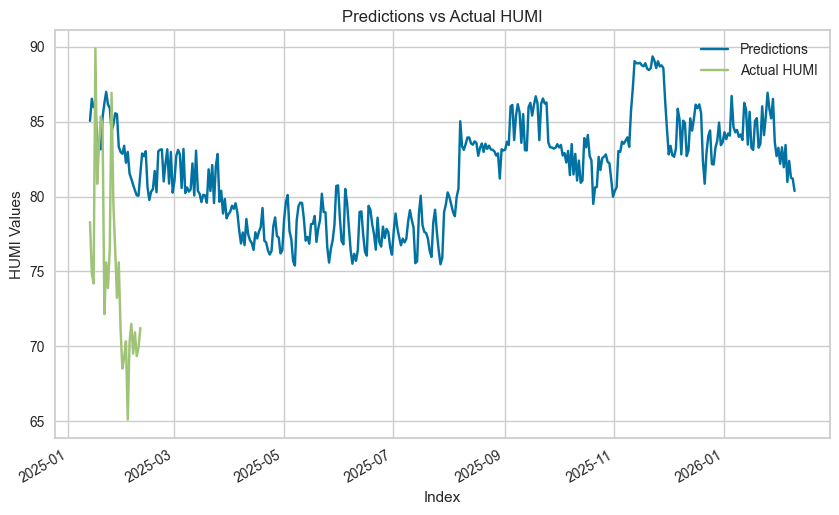

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

real_data = data_filtered.loc[start_date:end_date]
# สมมุติว่า result คือ DataFrame ที่รวม predictions กับ pm_10
result_plot = pd.concat([result_humi['prediction_label'].shift(-1), real_data['humidity']], axis=1)
result_plot.columns = ['Predictions', 'Actual HUMI']  # ตั้งชื่อคอลัมน์

# พล็อตข้อมูล
result_plot.plot(figsize=(10, 6))

# ตั้งชื่อกราฟ
plt.title('Predictions vs Actual HUMI')
plt.xlabel('Index')
plt.ylabel('HUMI Values')

# แสดงกราฟ
plt.show()

# Predict PM2.5

In [26]:
model_pm_2_5 = load_model("dt_model_eng")

Transformation Pipeline and Model Successfully Loaded


In [27]:
# อ่านไฟล์ CSV
data_pm_2_5 = pd.read_csv('../export_data/filtered_data_3_best.csv')

# ลบ 2 แถวล่าสุด
data_pm_2_5 = data_pm_2_5.drop(data_pm_2_5.index[-2:])

In [28]:
# ตั้ง 'timestamp' เป็น index หากยังไม่ได้ทำ
data_pm_2_5['timestamp'] = pd.to_datetime(data_pm_2_5['timestamp'])
data_pm_2_5.set_index('timestamp', inplace=True)

# ตั้งค่า freq ให้กับ index
data_pm_2_5 = data_pm_2_5.asfreq('D')  # 'D' สำหรับรายวัน

# แสดงแถวที่มีค่าหายไปก่อนเติม
print("แถวที่มีค่าหายไปก่อนเติม:")
print(data_pm_2_5[data_pm_2_5.isnull().any(axis=1)])

# เติมค่าที่หายไปด้วยการ interpolate แบบเส้นตรง
data_pm_2_5.interpolate(method='linear', inplace=True)

# แสดงแถวที่ยังมีค่า NaN หลังจากเติม (ถ้ามี)
missing_rows_after = data_pm_2_5[data_pm_2_5.isnull().any(axis=1)]
if not missing_rows_after.empty:
    print("แถวที่ยังมีค่าหายไปหลังเติม:")
    print(missing_rows_after)
else:
    print("ไม่มีค่าหายไปแล้ว")


# row = data_pm_2_5.loc["2023-09-30 07:00:00"]
# row

แถวที่มีค่าหายไปก่อนเติม:
                     humidity  pm_10  pm_2_5  pm_2_5_sp  temperature
timestamp                                                           
2023-09-30 07:00:00       NaN    NaN     NaN        NaN          NaN
ไม่มีค่าหายไปแล้ว


In [29]:
# กำหนดจำนวนวันที่ต้องการเพิ่ม
num_days = num_days

# สร้างวันที่ใหม่
next_date = data_pm_2_5.index[-1] + pd.Timedelta(days=1)
new_dates = pd.date_range(start=next_date, periods=num_days, freq='D')

# สร้างแถวใหม่
new_rows = pd.DataFrame({'value': range(40, 40 + num_days)}, index=new_dates)

# รวมข้อมูล (ป้องกัน index ซ้ำซ้อน)
data_pm_2_5 = pd.concat([data_pm_2_5, new_rows]).sort_index()

# ลบ index ที่ซ้ำกัน (ถ้ามี)
data_pm_2_5 = data_pm_2_5.loc[~data_pm_2_5.index.duplicated(keep='first')]

data_pm_2_5.tail(10)

,humidity,pm_10,pm_2_5,pm_2_5_sp,temperature,value
2026-01-31 07:00:00,NaN,NaN,NaN,NaN,NaN,395.0
2026-02-01 07:00:00,NaN,NaN,NaN,NaN,NaN,396.0
2026-02-02 07:00:00,NaN,NaN,NaN,NaN,NaN,397.0
2026-02-03 07:00:00,NaN,NaN,NaN,NaN,NaN,398.0
2026-02-04 07:00:00,NaN,NaN,NaN,NaN,NaN,399.0
2026-02-05 07:00:00,NaN,NaN,NaN,NaN,NaN,400.0
2026-02-06 07:00:00,NaN,NaN,NaN,NaN,NaN,401.0
2026-02-07 07:00:00,NaN,NaN,NaN,NaN,NaN,402.0
2026-02-08 07:00:00,NaN,NaN,NaN,NaN,NaN,403.0
2026-02-09 07:00:00,NaN,NaN,NaN,NaN,NaN,404.0


In [30]:
last_date_pm_2_5 = data_pm_2_5.index[-1].strftime('%Y-%m-%d')

In [31]:
import pandas as pd
# add humi predict column

# เลื่อนค่าของ prediction_label ไปข้างหน้า 1 วัน และตัดค่าแถวสุดท้ายที่ไม่มีผล
shifted_predictions = result_humi['prediction_label'].shift(-1).iloc[:-1]

# สมมติว่า data_pm_2_5 และ shifted_predictions มีอยู่แล้ว
# data_pm_2_5 เป็น DataFrame ที่มีคอลัมน์ 'humidity' และ index เป็น timestamp
# shifted_predictions เป็น Series ที่มี index เป็น timestamp ในช่วงวันที่ 2025-01-13 ถึง 2025-02-10

# แทนที่ค่าของคอลัมน์ 'humidity' ใน data_pm_2_5 ด้วยค่าจาก shifted_predictions ในวันที่ตรงกัน
data_pm_2_5.loc[shifted_predictions.index, 'humidity'] = shifted_predictions
data_pm_2_5


,humidity,pm_10,pm_2_5,pm_2_5_sp,temperature,value
2023-07-01 07:00:00,67.844074,12.634307,11.081056,8.796418,31.131941,NaN
2023-07-02 07:00:00,68.552865,11.350789,9.705165,7.547346,32.240924,NaN
2023-07-03 07:00:00,63.142228,13.457203,11.469033,8.783577,35.841610,NaN
2023-07-04 07:00:00,61.741030,29.167827,26.188719,25.657382,36.269393,NaN
2023-07-05 07:00:00,62.085527,28.747735,25.508711,23.605575,36.176134,NaN
...,...,...,...,...,...,...
2026-02-05 07:00:00,80.976344,NaN,NaN,NaN,NaN,400.0
2026-02-06 07:00:00,82.377469,NaN,NaN,NaN,NaN,401.0
2026-02-07 07:00:00,81.261277,NaN,NaN,NaN,NaN,402.0
2026-02-08 07:00:00,81.190988,NaN,NaN,NaN,NaN,403.0


In [32]:
# เลื่อนค่าของ prediction_label ไปข้างหน้า 1 วัน และตัดค่าแถวสุดท้ายที่ไม่มีผล
shifted_predictions_temp = result['prediction_label'].shift(-1).iloc[:-1]

# กรองข้อมูลที่มีวันที่น้อยกว่าหรือเท่ากับ last_day
shifted_predictions_temp = shifted_predictions_temp[:last_date_pm_2_5]

# แทนที่ค่าของคอลัมน์ 'temperature' ใน data_pm_2_5
data_pm_2_5.loc[shifted_predictions_temp.index, 'temperature'] = shifted_predictions_temp
data_pm_2_5

,humidity,pm_10,pm_2_5,pm_2_5_sp,temperature,value
2023-07-01 07:00:00,67.844074,12.634307,11.081056,8.796418,31.131941,NaN
2023-07-02 07:00:00,68.552865,11.350789,9.705165,7.547346,32.240924,NaN
2023-07-03 07:00:00,63.142228,13.457203,11.469033,8.783577,35.841610,NaN
2023-07-04 07:00:00,61.741030,29.167827,26.188719,25.657382,36.269393,NaN
2023-07-05 07:00:00,62.085527,28.747735,25.508711,23.605575,36.176134,NaN
...,...,...,...,...,...,...
2026-02-05 07:00:00,80.976344,NaN,NaN,NaN,27.836527,400.0
2026-02-06 07:00:00,82.377469,NaN,NaN,NaN,28.296993,401.0
2026-02-07 07:00:00,81.261277,NaN,NaN,NaN,28.040734,402.0
2026-02-08 07:00:00,81.190988,NaN,NaN,NaN,28.185290,403.0


In [33]:
data_pm_2_5["year"] = data_pm_2_5.index.year
data_pm_2_5["month"] = data_pm_2_5.index.month
data_pm_2_5["day"] = data_pm_2_5.index.day
data_pm_2_5["day_of_week"] = data_pm_2_5.index.dayofweek  # 0 = Monday, 6 = Sunday
data_pm_2_5["week_of_year"] = data_pm_2_5.index.isocalendar().week  # ค่าจะเป็น int64

# สมมติว่า data_pm_2_5 มี index เป็น datetime อยู่แล้ว
def assign_season(month):
    if month in [2, 3, 4]:  # ก.พ. - เม.ย.
        return "summer"        # ฤดูร้อน
    elif month in [5, 6, 7]:  # พ.ค. - ก.ค.
        return "early_rainy"   # ต้นฤดูฝน
    else:  # ส.ค. - ม.ค.
        return "late_rainy"    # ปลายฤดูฝน

season_mapping = {'summer': 0, 'early_rainy': 1, 'late_rainy': 2}
data_pm_2_5["season"] = data_pm_2_5.index.month.map(assign_season)
data_pm_2_5['season'] = data_pm_2_5['season'].map(season_mapping)

data_pm_2_5["is_weekend"] = data_pm_2_5.index.dayofweek.isin([5, 6]).astype(int)

In [34]:
data_pm_2_5['dew_point'] = data_pm_2_5['temperature'] - ((100 - data_pm_2_5['humidity']) / 5)
# อัตราส่วนของอุณหภูมิต่อความชื้น
data_pm_2_5["temp_humidity_ratio"] = data_pm_2_5["temperature"] / (data_pm_2_5["humidity"] + 1)
# ดัชนีความร้อน (Heat Index) หรืออุณหภูมิที่รับรู้
T = data_pm_2_5["temperature"]
RH = data_pm_2_5["humidity"]

data_pm_2_5["heat_index"] = -42.379 + (2.04901523 * T) + (10.14333127 * RH) - (0.22475541 * T * RH) - \
                   (0.00683783 * T**2) - (0.05481717 * RH**2) + (0.00122874 * T**2 * RH) + \
                   (0.00085282 * T * RH**2) - (0.00000199 * T**2 * RH**2)

# ความชื้นสัมพัทธ์เชิงดัชนี
data_pm_2_5["rh_index"] = data_pm_2_5["humidity"] ** 2 / (data_pm_2_5["temperature"] + 1)

In [35]:
import pandas as pd
import numpy as np

# เพิ่มฟีเจอร์ day_of_year
data_pm_2_5['date'] = pd.to_datetime(data_pm_2_5[['year', 'month', 'day']])
data_pm_2_5['day_of_year'] = data_pm_2_5['date'].dt.dayofyear

# เพิ่มฟีเจอร์ month_sin และ month_cos
data_pm_2_5['month_sin'] = np.sin(2 * np.pi * data_pm_2_5['month'] / 12)
data_pm_2_5['month_cos'] = np.cos(2 * np.pi * data_pm_2_5['month'] / 12)

# เพิ่มฟีเจอร์ day_of_week_sin และ day_of_week_cos
data_pm_2_5['day_of_week_sin'] = np.sin(2 * np.pi * data_pm_2_5['day_of_week'] / 7)
data_pm_2_5['day_of_week_cos'] = np.cos(2 * np.pi * data_pm_2_5['day_of_week'] / 7)

lag_size = 30
for i in range(1,lag_size+1):
    data_pm_2_5[f'pm_2_5_lag_{i}'] = data_pm_2_5['pm_2_5'].shift(i)

data_pm_2_5['humidity_lag_1'] = data_pm_2_5['humidity'].shift(1)
data_pm_2_5['humidity_lag_2'] = data_pm_2_5['humidity'].shift(2)
data_pm_2_5['humidity_lag_3'] = data_pm_2_5['humidity'].shift(3)
data_pm_2_5['humidity_lag_7'] = data_pm_2_5['humidity'].shift(7)

data_pm_2_5['temperature_lag_1'] = data_pm_2_5['temperature'].shift(1)
data_pm_2_5['temperature_lag_2'] = data_pm_2_5['temperature'].shift(2)
data_pm_2_5['temperature_lag_3'] = data_pm_2_5['temperature'].shift(3)
data_pm_2_5['temperature_lag_7'] = data_pm_2_5['temperature'].shift(7)

In [41]:
data_filtered_2 = data_pm_2_5.loc['2023-09':]

In [42]:
data_filtered = data_pm_2_5.loc['2023-09':'2025-2-11']  # ดึงข้อมูลตั้งแต่กันยายน 2023 เป็นต้นไป

In [43]:
# สมมติว่า data มีจำนวนวันทั้งหมด
total_data = len(data_filtered)

# จำนวนวันที่ต้องการเป็น test data
test_days = 7

# คำนวณสัดส่วนของ 30 วันในข้อมูลทั้งหมด
test_size = test_days / total_data

from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data_filtered, test_size=test_size, shuffle=False)

In [45]:
from pycaret.regression import RegressionExperiment
exp1 = RegressionExperiment()
exp1.setup(data=train_data, target='pm_2_5', session_id=123)
# iterative_imputation_iters=100, remove_outliers = True

,Description,Value
0,Session id,123
1,Target,pm_2_5
2,Target type,Regression
3,Original data shape,"(523, 61)"
4,Transformed data shape,"(523, 62)"
5,Transformed train set shape,"(366, 62)"
6,Transformed test set shape,"(157, 62)"
7,Numeric features,59
8,Date features,1
9,Rows with missing values,100.0%


In [47]:
# compare baseline models
best = exp1.compare_models(n_select=15)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.2074,0.1462,0.3476,0.9987,0.0154,0.0110,0.0710
gbr,Gradient Boosting Regressor,0.2747,0.1670,0.3992,0.9984,0.0193,0.0151,0.0870
omp,Orthogonal Matching Pursuit,0.3075,0.2375,0.4707,0.9979,0.0183,0.0149,0.0100
en,Elastic Net,0.3204,0.2557,0.4819,0.9978,0.0213,0.0168,0.0100
br,Bayesian Ridge,0.3148,0.2542,0.4811,0.9978,0.0186,0.0154,0.0100
lasso,Lasso Regression,0.3192,0.2506,0.4851,0.9977,0.0199,0.0158,0.1620
llar,Lasso Least Angle Regression,0.3199,0.2511,0.4854,0.9977,0.0200,0.0159,0.0100
rf,Random Forest Regressor,0.3359,0.3145,0.5333,0.9972,0.0246,0.0181,0.1260
ridge,Ridge Regression,0.3394,0.4459,0.5877,0.9954,0.0384,0.0176,0.0100
ada,AdaBoost Regressor,0.5283,0.4975,0.6989,0.9951,0.0583,0.0377,0.0340


Processing model: ExtraTreesRegressor


Processing model: GradientBoostingRegressor


Processing model: OrthogonalMatchingPursuit


Processing model: ElasticNet


Processing model: BayesianRidge


Processing model: Lasso


Processing model: LassoLars


Processing model: RandomForestRegressor


Processing model: Ridge


Processing model: AdaBoostRegressor


Processing model: DecisionTreeRegressor


Processing model: HuberRegressor


Processing model: LGBMRegressor


Processing model: LinearRegression


Processing model: KNeighborsRegressor


  File "d:\Normal File\Coder\MINI_PROJECT_1-2\pycaret_venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


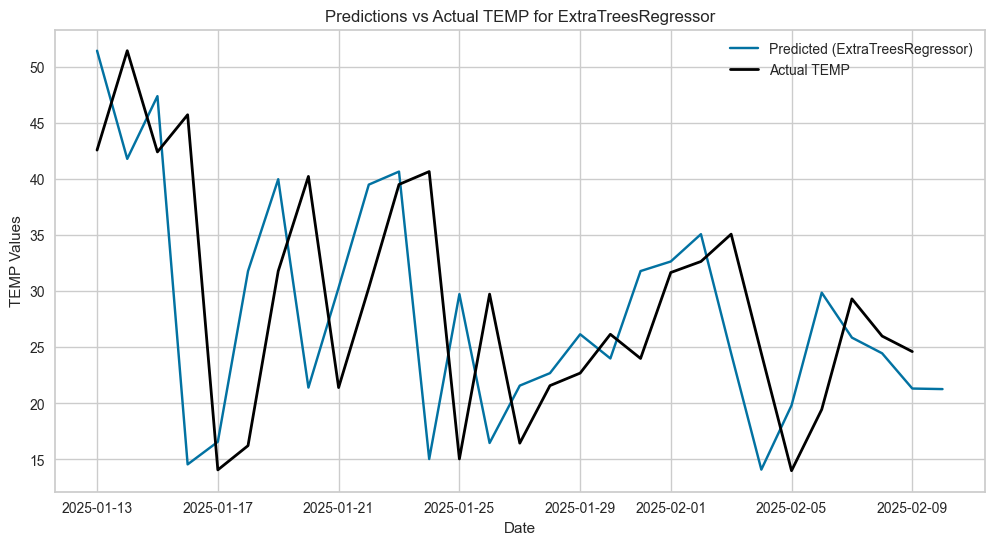

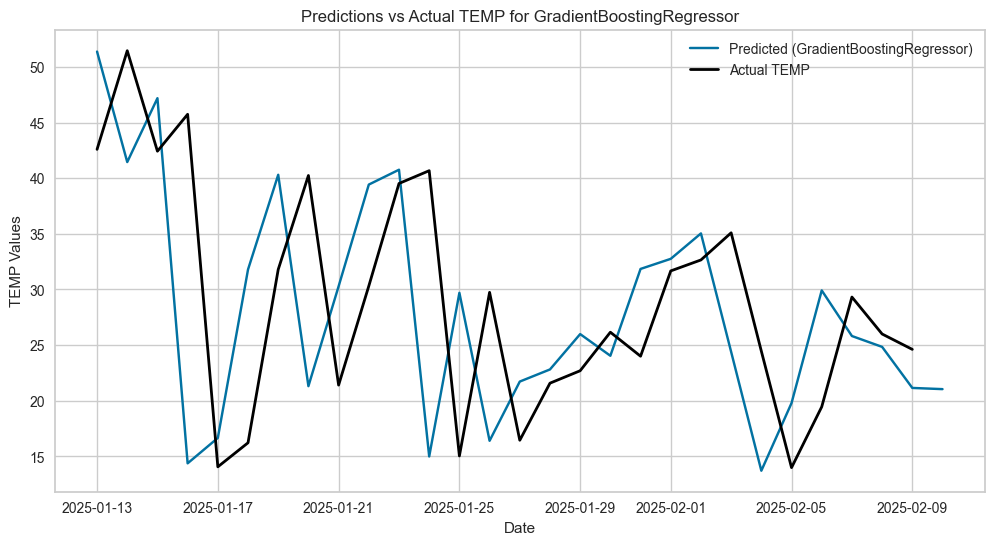

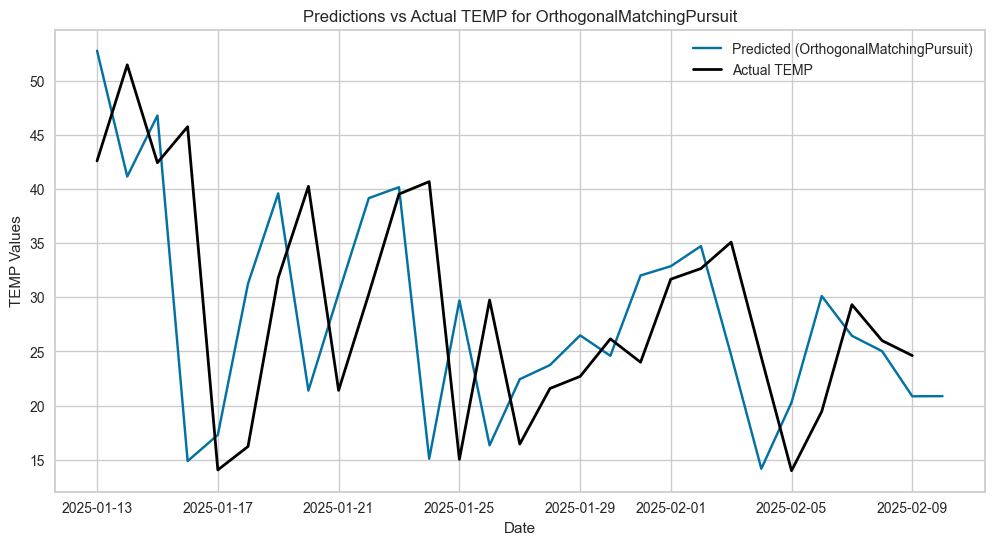

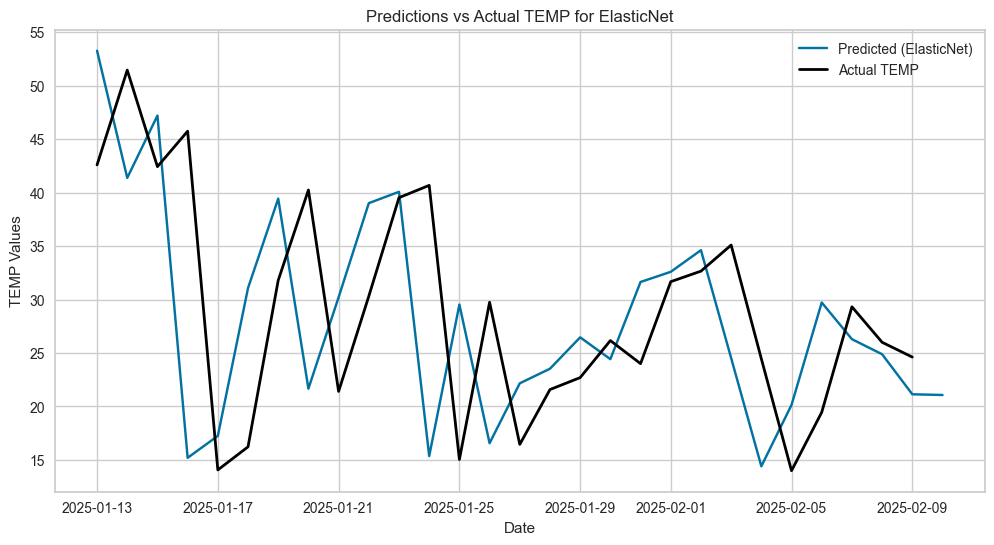

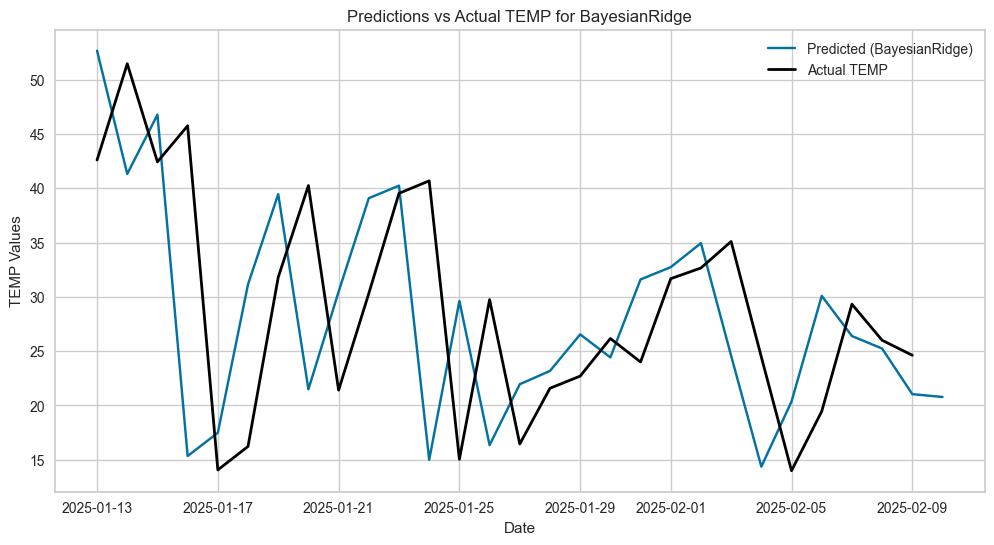

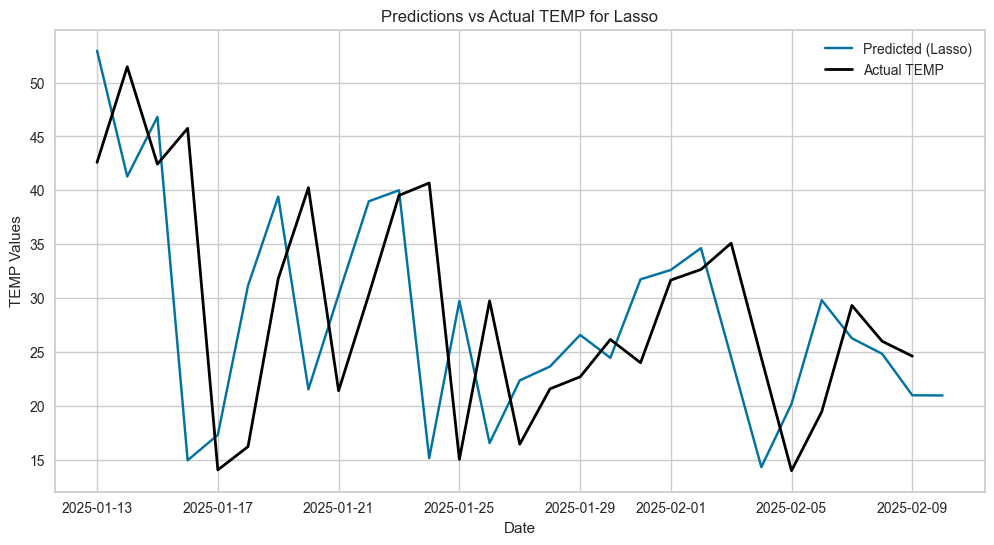

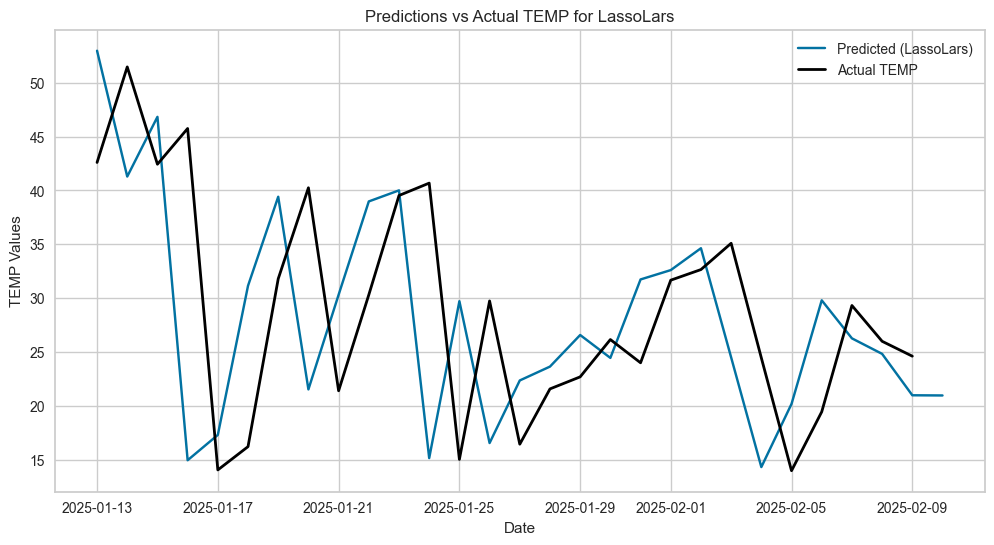

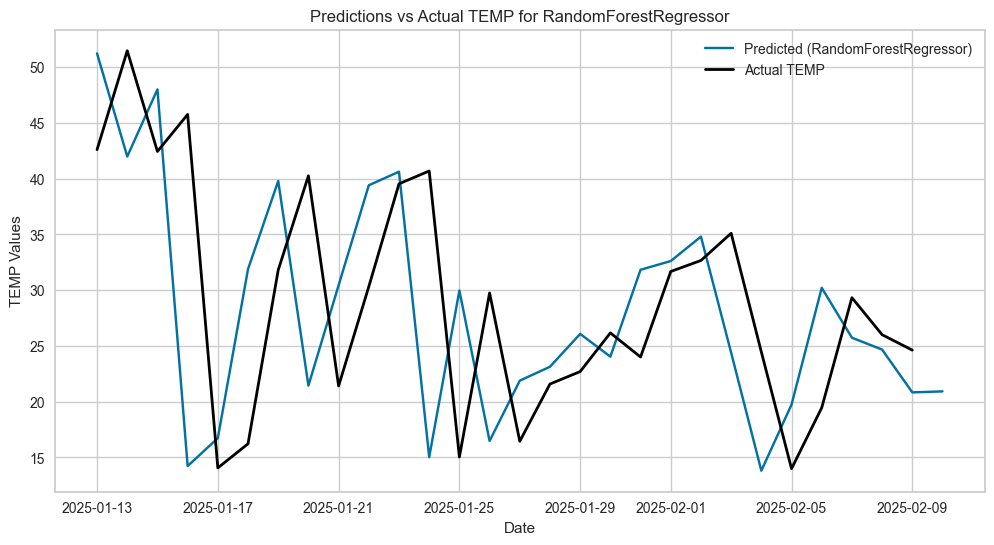

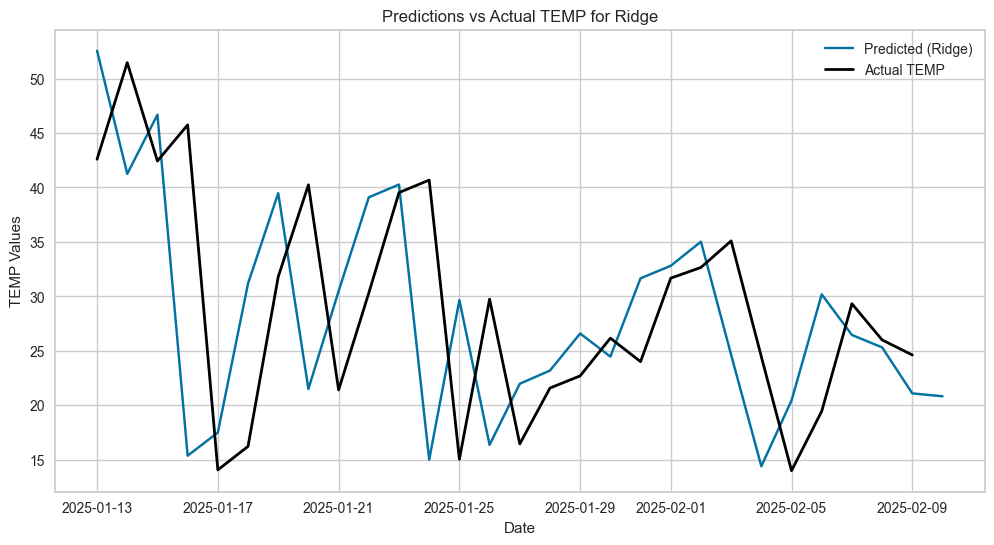

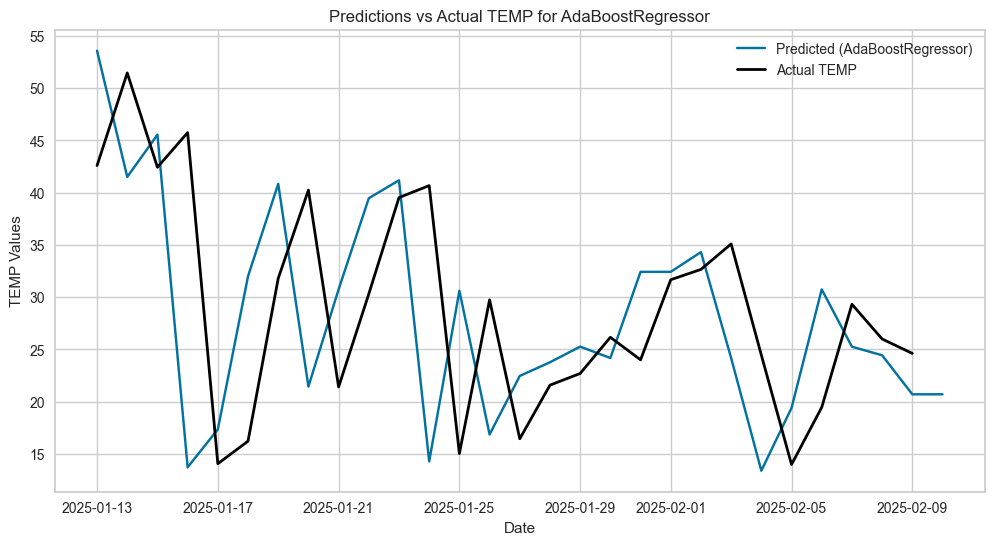

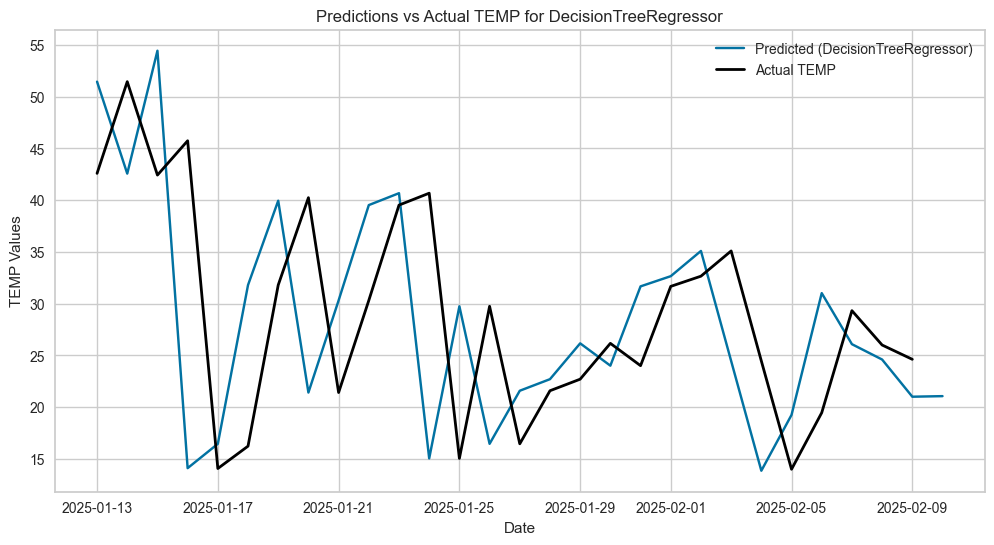

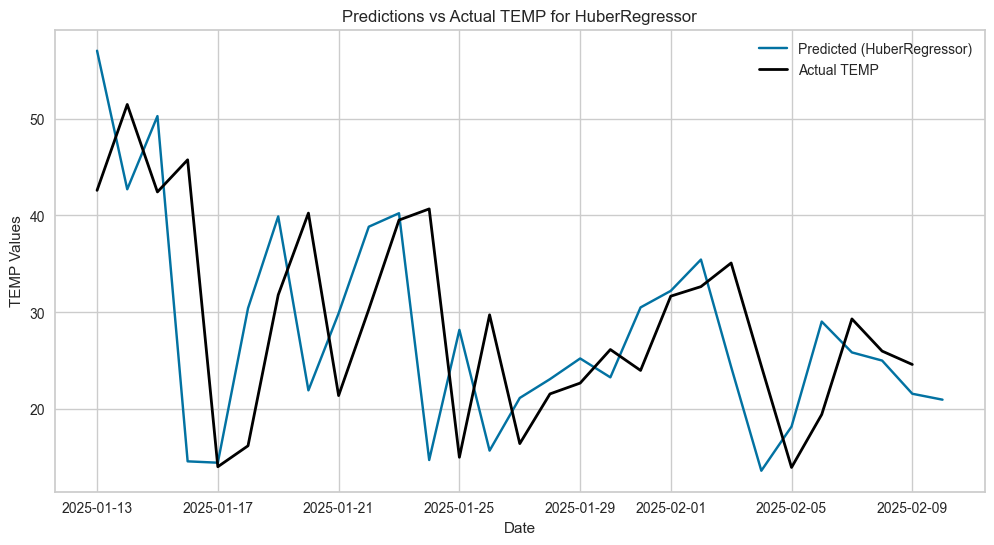

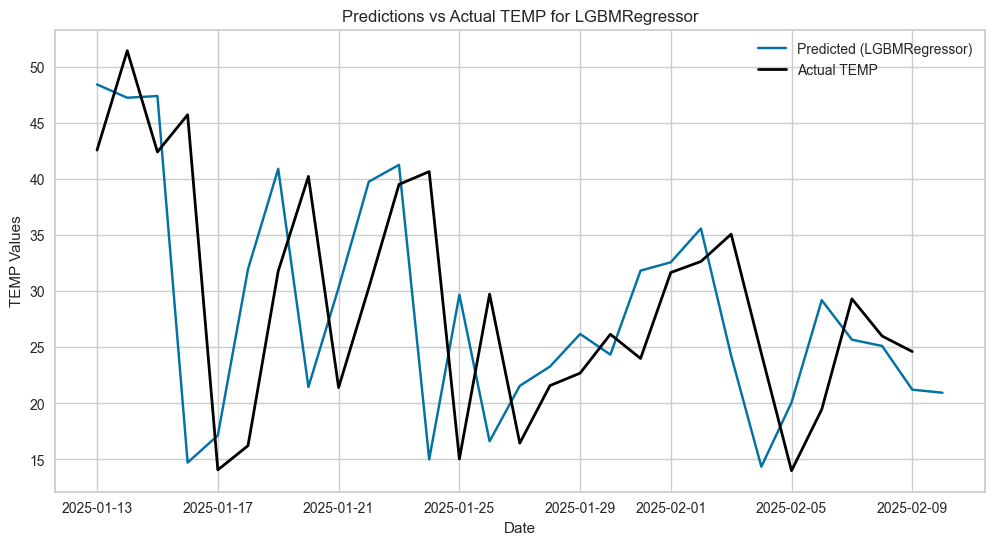

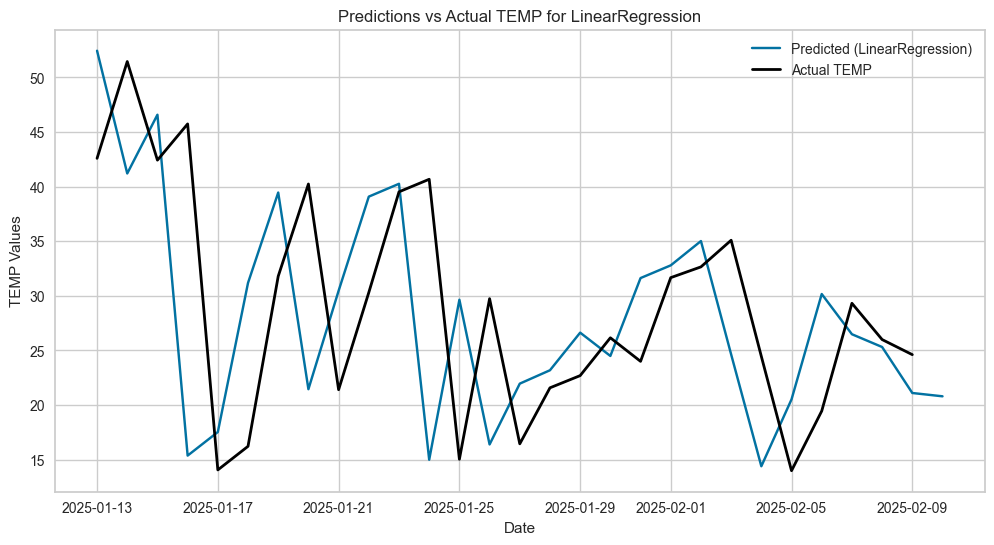

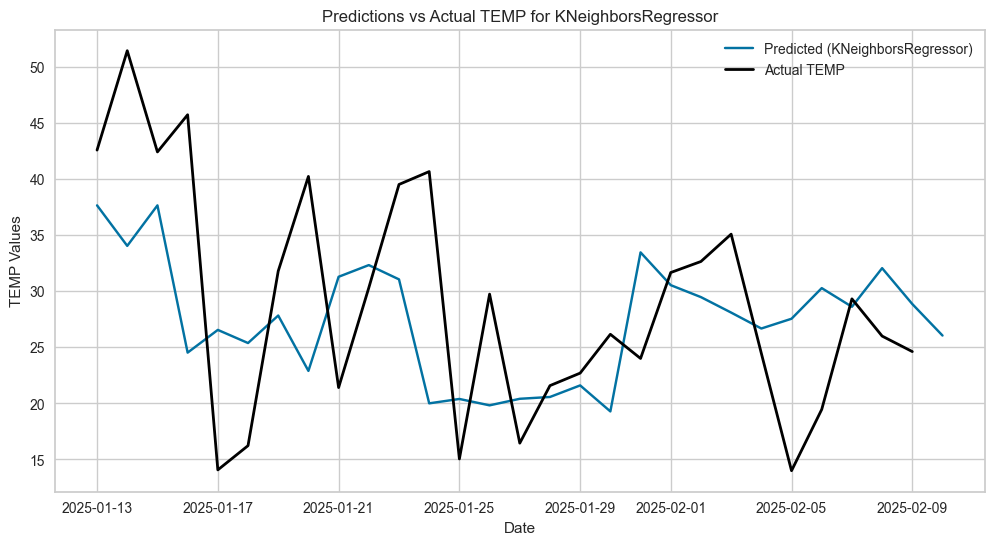

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

# แปลง index เป็น datetime และลบเวลาออก
x = data_filtered_2.copy()
x.index = pd.to_datetime(x.index).normalize()

# เก็บผลลัพธ์ของแต่ละโมเดล
result_dict = {}

# รายชื่อโมเดลทั้งหมดจาก best_list
model_names = {model.__class__.__name__: model for model in best}

start_date = "2025-01-13"
end_date = "2025-02-11"

# วนลูปผ่านทุกโมเดล
for model_name, model in model_names.items():
    print(f"Processing model: {model_name}")

    data_compare = x.loc[:'2025-01-12'].copy()  # ใช้ copy() ป้องกัน Warning
    result = pd.DataFrame()

    for date in pd.date_range(start=start_date, end=end_date, freq="D"):
        # ลบเวลาออกจากวันที่
        date = pd.to_datetime(date).normalize()  # ลบเวลาออกจากตัวแปร date

        # ตรวจสอบว่าใน x มีข้อมูลในวันที่นี้หรือไม่
        if date not in x.index:
            print(f"⚠️ Warning: Date {date} not found in x index.")
            continue

        # ดึงข้อมูลของวันที่ต้องการ
        test_1 = x.loc[[date]].copy()

        # ใส่เข้าไป
        data_compare = pd.concat([data_compare, test_1], axis=0)

        lag_size = 30
        for i in range(1, lag_size + 1):
            test_1[f'pm_2_5_lag_{i}'] = data_compare['pm_2_5'].shift(i)

        # # ลบค่า NaN ที่เกิดจากการ shift
        test_1.drop(columns=('pm_2_5'), inplace=True)

        # ทำนายค่า
        predict_test_1 = exp1.predict_model(model, data=test_1)

        # อัปเดต data_compare
        predict_test_1.index = [date]  # กำหนด index เป็นวันที่พยากรณ์
        data_compare.loc[date, 'pm_2_5'] = predict_test_1['prediction_label'].values[0]

        # บันทึกผลลัพธ์
        result = pd.concat([result, predict_test_1], axis=0)

    # บันทึกผลลัพธ์ของโมเดลนี้ลง dict
    result_dict[model_name] = result

# --------------------------------------------
# พล็อตกราฟเปรียบเทียบทุกโมเดล
# --------------------------------------------
real_data = x.loc[start_date:end_date]

# วนลูปพล็อตกราฟทีละโมเดล
for model_name, result in result_dict.items():
    plt.figure(figsize=(12, 6))
    
    result_plot = pd.concat([result['prediction_label'].shift(-1), real_data['pm_2_5']], axis=1)
    result_plot.columns = ['Predictions', 'Actual TEMP']

    plt.plot(result_plot.index, result_plot['Predictions'], label=f"Predicted ({model_name})")
    plt.plot(real_data.index, real_data['pm_2_5'], label="Actual TEMP", color="black", linewidth=2)
    
    # ตั้งค่ากราฟ
    plt.title(f'Predictions vs Actual TEMP for {model_name}')
    plt.xlabel('Date')
    plt.ylabel('TEMP Values')
    plt.legend()

    # แสดงกราฟ
    plt.show()

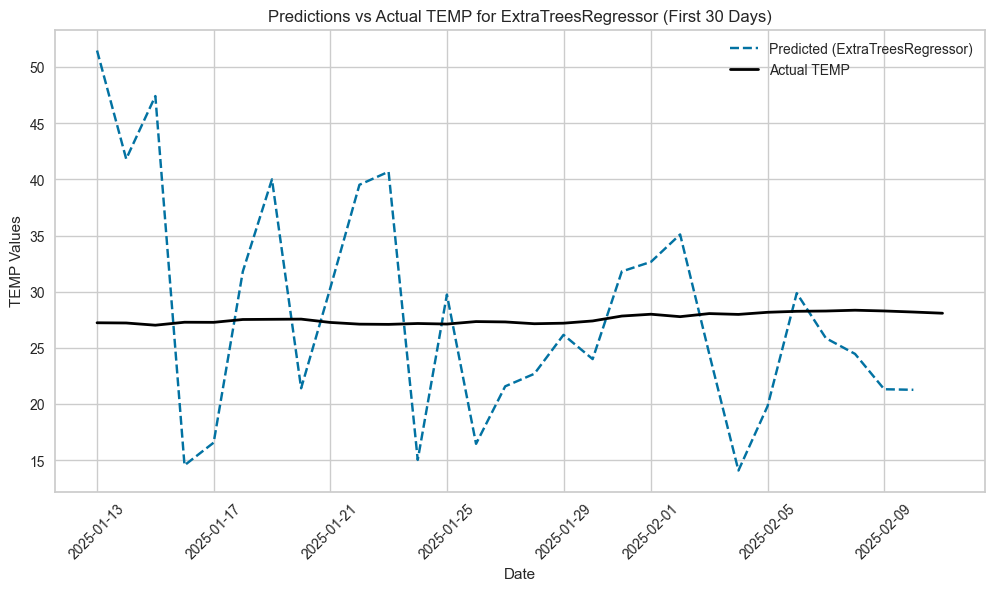


📊 Model Performance Metrics:
Model: ExtraTreesRegressor
Start Date: 2025-01-13 00:00:00, End Date: 2025-02-11
R² Score: -512.4057
Mean Absolute Error (MAE): 8.2213
Root Mean Squared Error (RMSE): 9.9581
Mean Absolute Percentage Error (MAPE): 29.94%
Accuracy: 70.06%
--------------------------------------------------


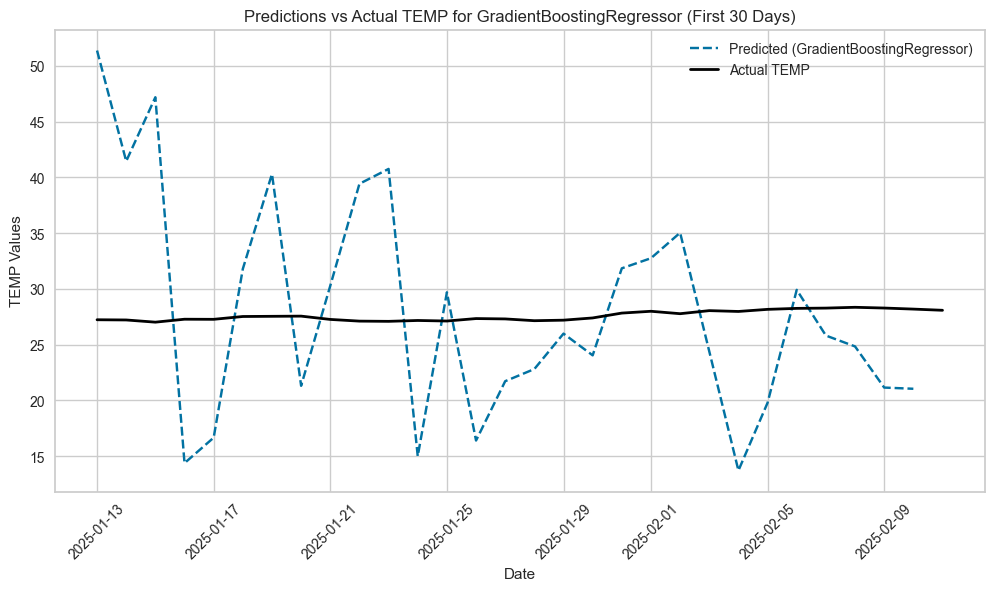


📊 Model Performance Metrics:
Model: GradientBoostingRegressor
Start Date: 2025-01-13 00:00:00, End Date: 2025-02-11
R² Score: -513.0330
Mean Absolute Error (MAE): 8.2349
Root Mean Squared Error (RMSE): 9.9642
Mean Absolute Percentage Error (MAPE): 29.99%
Accuracy: 70.01%
--------------------------------------------------


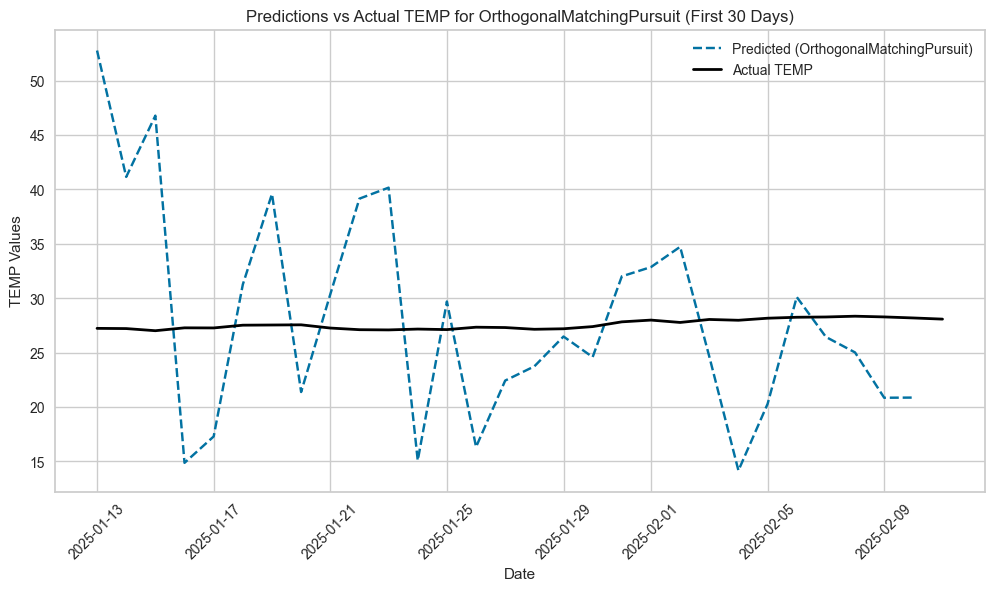


📊 Model Performance Metrics:
Model: OrthogonalMatchingPursuit
Start Date: 2025-01-13 00:00:00, End Date: 2025-02-11
R² Score: -500.7669
Mean Absolute Error (MAE): 8.0036
Root Mean Squared Error (RMSE): 9.8446
Mean Absolute Percentage Error (MAPE): 29.15%
Accuracy: 70.85%
--------------------------------------------------


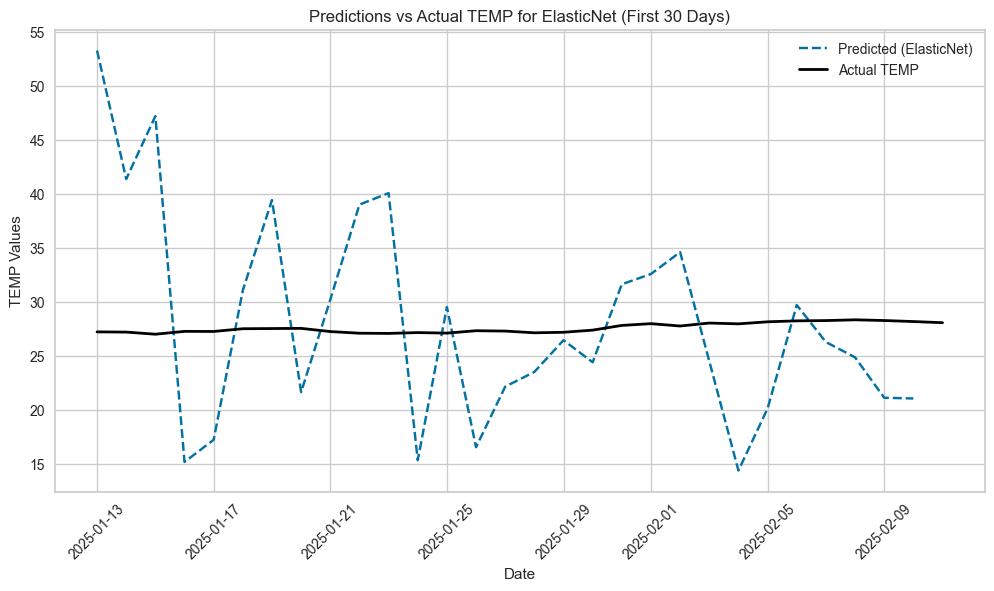


📊 Model Performance Metrics:
Model: ElasticNet
Start Date: 2025-01-13 00:00:00, End Date: 2025-02-11
R² Score: -501.4846
Mean Absolute Error (MAE): 7.9558
Root Mean Squared Error (RMSE): 9.8516
Mean Absolute Percentage Error (MAPE): 28.98%
Accuracy: 71.02%
--------------------------------------------------


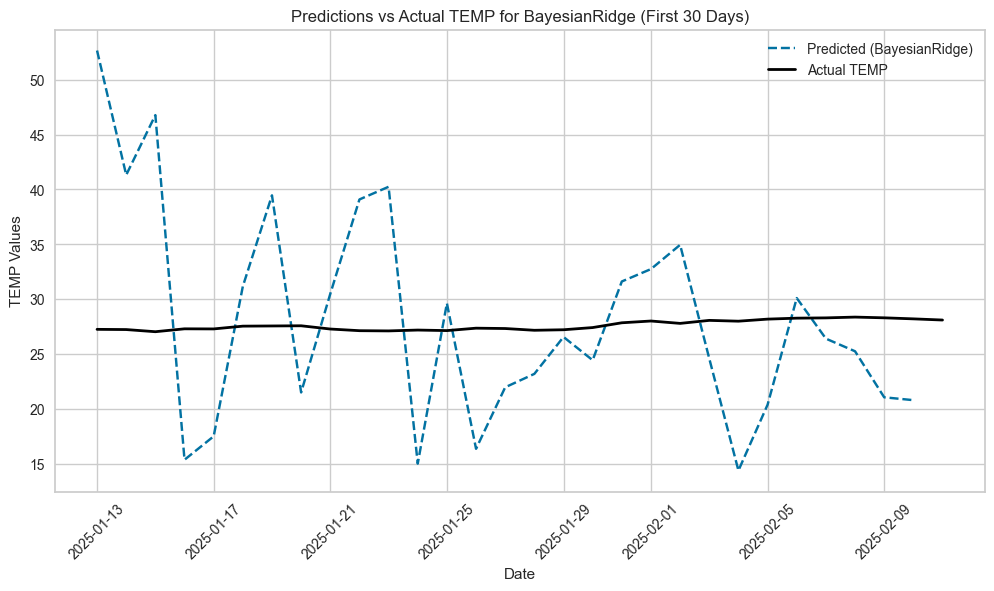


📊 Model Performance Metrics:
Model: BayesianRidge
Start Date: 2025-01-13 00:00:00, End Date: 2025-02-11
R² Score: -497.4284
Mean Absolute Error (MAE): 7.9880
Root Mean Squared Error (RMSE): 9.8118
Mean Absolute Percentage Error (MAPE): 29.09%
Accuracy: 70.91%
--------------------------------------------------


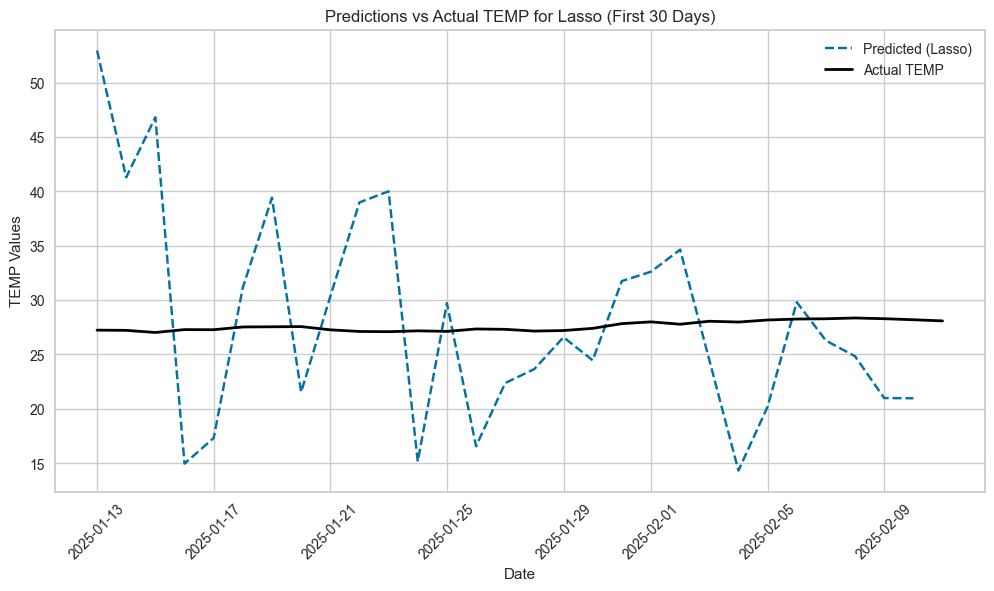


📊 Model Performance Metrics:
Model: Lasso
Start Date: 2025-01-13 00:00:00, End Date: 2025-02-11
R² Score: -497.6717
Mean Absolute Error (MAE): 7.9579
Root Mean Squared Error (RMSE): 9.8142
Mean Absolute Percentage Error (MAPE): 28.98%
Accuracy: 71.02%
--------------------------------------------------


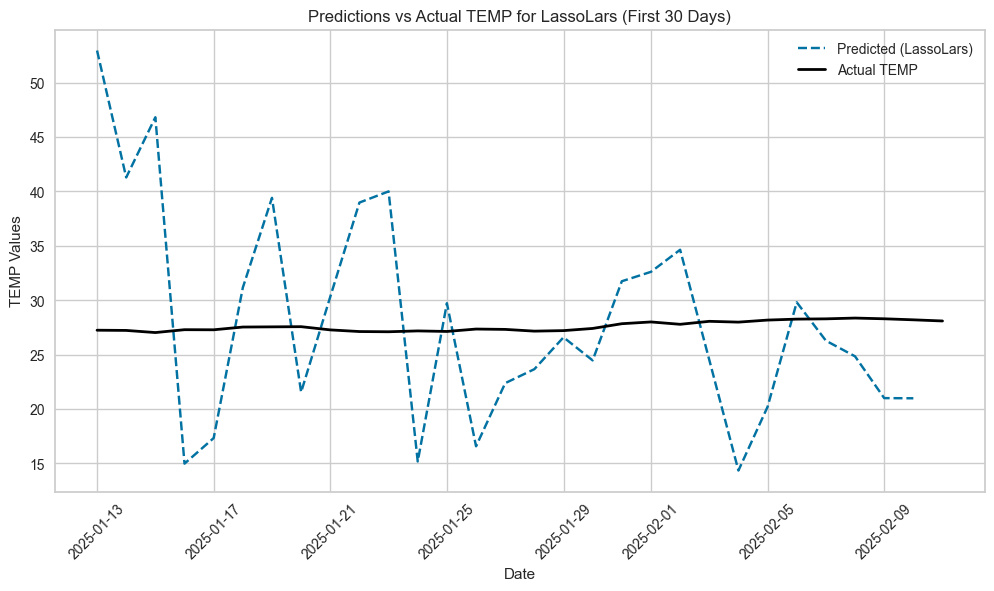


📊 Model Performance Metrics:
Model: LassoLars
Start Date: 2025-01-13 00:00:00, End Date: 2025-02-11
R² Score: -497.8346
Mean Absolute Error (MAE): 7.9581
Root Mean Squared Error (RMSE): 9.8158
Mean Absolute Percentage Error (MAPE): 28.98%
Accuracy: 71.02%
--------------------------------------------------


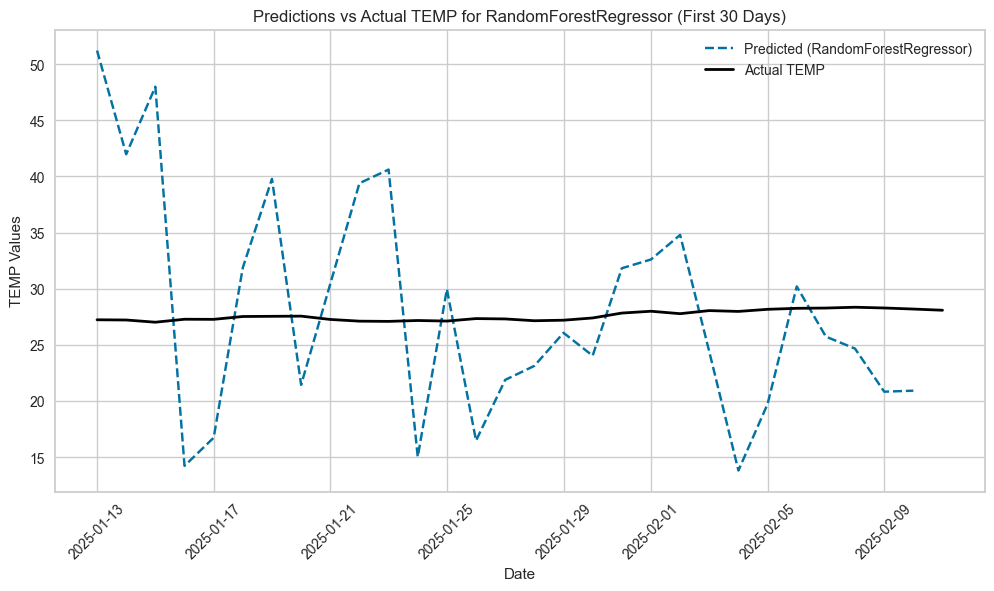


📊 Model Performance Metrics:
Model: RandomForestRegressor
Start Date: 2025-01-13 00:00:00, End Date: 2025-02-11
R² Score: -516.8587
Mean Absolute Error (MAE): 8.2619
Root Mean Squared Error (RMSE): 10.0012
Mean Absolute Percentage Error (MAPE): 30.09%
Accuracy: 69.91%
--------------------------------------------------


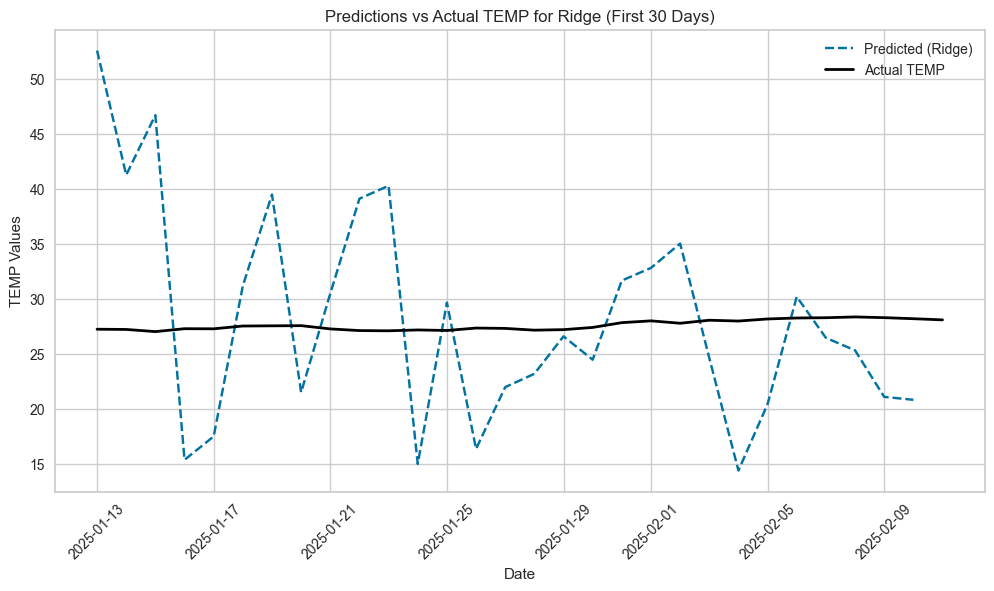


📊 Model Performance Metrics:
Model: Ridge
Start Date: 2025-01-13 00:00:00, End Date: 2025-02-11
R² Score: -495.2607
Mean Absolute Error (MAE): 7.9742
Root Mean Squared Error (RMSE): 9.7904
Mean Absolute Percentage Error (MAPE): 29.04%
Accuracy: 70.96%
--------------------------------------------------


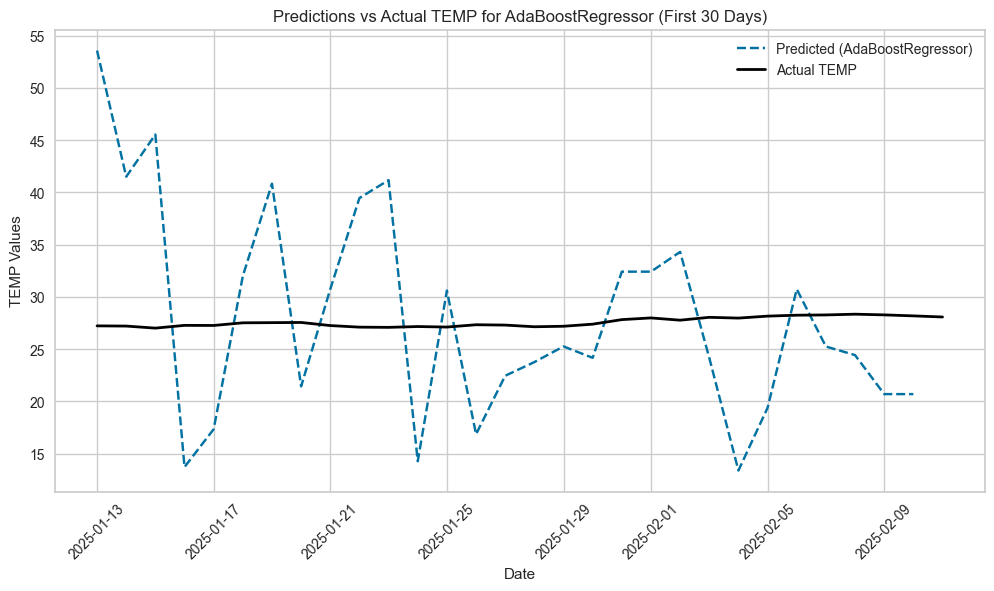


📊 Model Performance Metrics:
Model: AdaBoostRegressor
Start Date: 2025-01-13 00:00:00, End Date: 2025-02-11
R² Score: -533.0434
Mean Absolute Error (MAE): 8.4136
Root Mean Squared Error (RMSE): 10.1563
Mean Absolute Percentage Error (MAPE): 30.63%
Accuracy: 69.37%
--------------------------------------------------


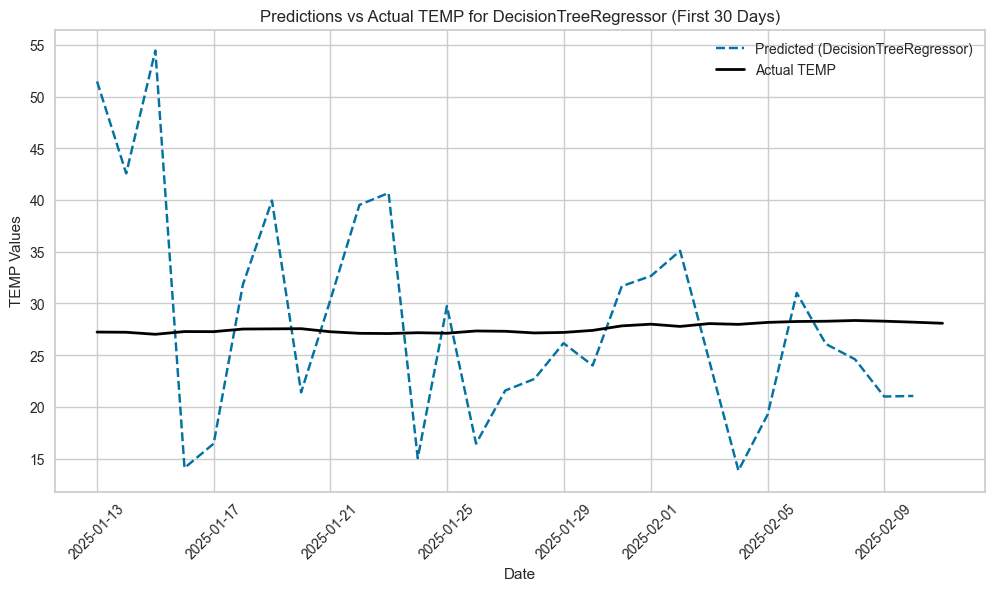


📊 Model Performance Metrics:
Model: DecisionTreeRegressor
Start Date: 2025-01-13 00:00:00, End Date: 2025-02-11
R² Score: -583.7035
Mean Absolute Error (MAE): 8.5781
Root Mean Squared Error (RMSE): 10.6271
Mean Absolute Percentage Error (MAPE): 31.25%
Accuracy: 68.75%
--------------------------------------------------


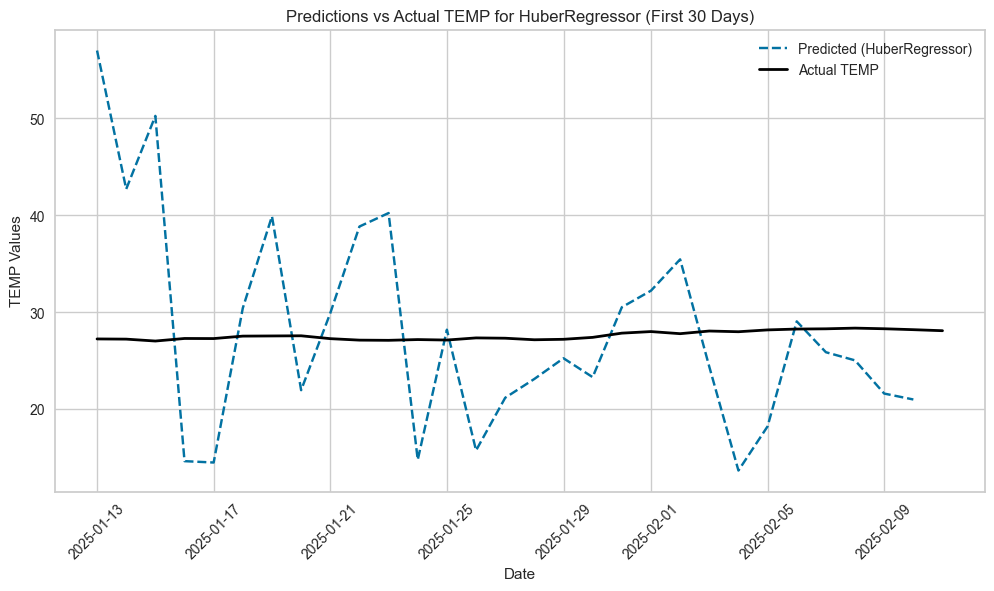


📊 Model Performance Metrics:
Model: HuberRegressor
Start Date: 2025-01-13 00:00:00, End Date: 2025-02-11
R² Score: -602.7630
Mean Absolute Error (MAE): 8.5061
Root Mean Squared Error (RMSE): 10.7989
Mean Absolute Percentage Error (MAPE): 30.99%
Accuracy: 69.01%
--------------------------------------------------


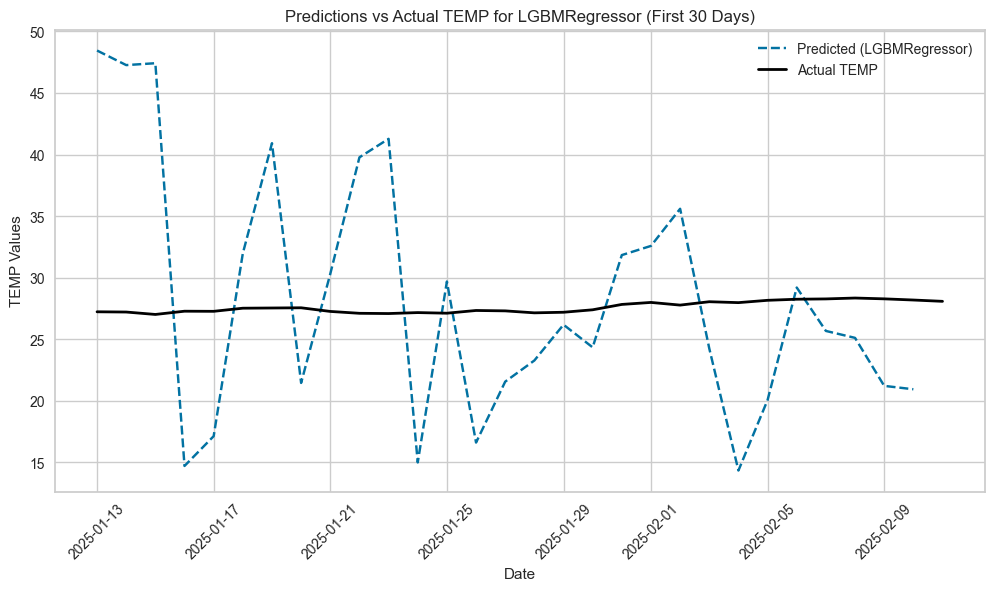


📊 Model Performance Metrics:
Model: LGBMRegressor
Start Date: 2025-01-13 00:00:00, End Date: 2025-02-11
R² Score: -525.4149
Mean Absolute Error (MAE): 8.2892
Root Mean Squared Error (RMSE): 10.0835
Mean Absolute Percentage Error (MAPE): 30.20%
Accuracy: 69.80%
--------------------------------------------------


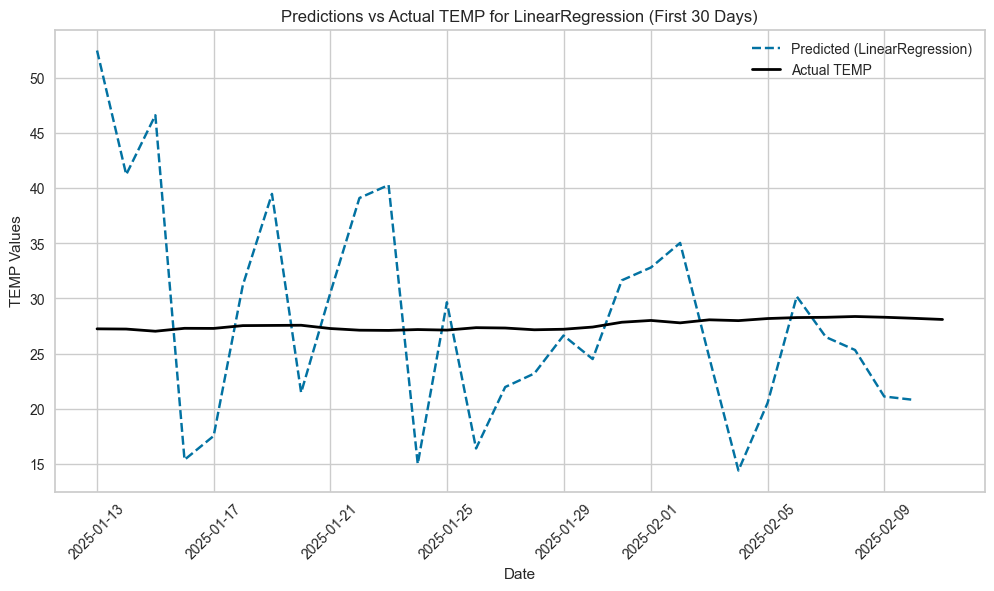


📊 Model Performance Metrics:
Model: LinearRegression
Start Date: 2025-01-13 00:00:00, End Date: 2025-02-11
R² Score: -492.7614
Mean Absolute Error (MAE): 7.9548
Root Mean Squared Error (RMSE): 9.7657
Mean Absolute Percentage Error (MAPE): 28.97%
Accuracy: 71.03%
--------------------------------------------------


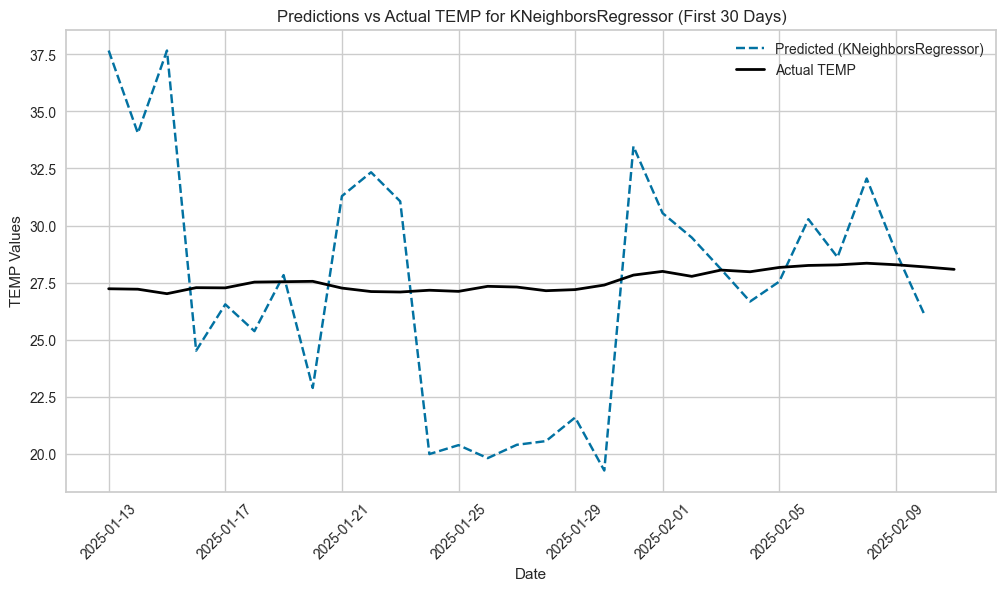


📊 Model Performance Metrics:
Model: KNeighborsRegressor
Start Date: 2025-01-13 00:00:00, End Date: 2025-02-11
R² Score: -136.5046
Mean Absolute Error (MAE): 4.1712
Root Mean Squared Error (RMSE): 5.1535
Mean Absolute Percentage Error (MAPE): 15.24%
Accuracy: 84.76%
--------------------------------------------------


In [49]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# หาวันแรกสุดของข้อมูลจริง
start_date = real_data.index.min()
end_date = start_date + pd.DateOffset(days=29)  # 30 วันแรก (นับรวมวันแรก)

# วนลูปพล็อตกราฟทีละโมเดล
for model_name, result in result_dict.items():
    plt.figure(figsize=(12, 6))
    
    # แปลง index เป็น DatetimeIndex เผื่อมีปัญหา
    result.index = pd.to_datetime(result.index)
    real_data.index = pd.to_datetime(real_data.index)

    # เลือกเฉพาะ 30 วันแรก
    result_plot = pd.concat([result['prediction_label'].shift(-1), real_data['temperature']], axis=1)
    result_plot.columns = ['Predictions', 'Actual TEMP']
    result_plot = result_plot.loc[start_date:end_date]  # ตัดข้อมูลให้เหลือแค่ 30 วันแรก

    # ลบ NaN ที่เกิดจากการ shift
    valid_idx = result_plot.dropna().index
    y_true = result_plot.loc[valid_idx, 'Actual TEMP']
    y_pred = result_plot.loc[valid_idx, 'Predictions']

    # คำนวณ Metrics
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    # จัดการค่า 0 ใน y_true เพื่อหลีกเลี่ยง division by zero ใน MAPE
    mask = y_true != 0
    mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100 if mask.any() else np.nan
    accuracy = 100 - mape if not np.isnan(mape) else np.nan  # คำนวณ Accuracy

    # พล็อตข้อมูล
    plt.plot(result_plot.index, result_plot['Predictions'], label=f"Predicted ({model_name})", linestyle='dashed')
    plt.plot(real_data.loc[start_date:end_date].index, real_data.loc[start_date:end_date, 'temperature'], 
             label="Actual TEMP", color="black", linewidth=2)
    
    # ตั้งค่ากราฟ
    plt.title(f'Predictions vs Actual TEMP for {model_name} (First 30 Days)')
    plt.xlabel('Date')
    plt.ylabel('TEMP Values')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)

    # แสดงกราฟ
    plt.show()

    # แสดงค่า Metrics ของโมเดลนี้
    print("\n📊 Model Performance Metrics:")
    print(f"Model: {model_name}")
    print(f"Start Date: {start_date}, End Date: {end_date.strftime('%Y-%m-%d')}")
    print(f"R² Score: {r2:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%" if not np.isnan(mape) else "MAPE: N/A (y_true contains zero values)")
    print(f"Accuracy: {accuracy:.2f}%" if not np.isnan(accuracy) else "Accuracy: N/A")
    print("-" * 50)


In [ ]:
stop

# CHECK ACCURENCY

In [ ]:
# อ่านไฟล์ CSV
data_real = pd.read_csv('../export_data/filtered_data_3_best.csv')

# ตั้ง 'timestamp' เป็น index หากยังไม่ได้ทำ
data_real['timestamp'] = pd.to_datetime(data_real['timestamp'])
data_real.set_index('timestamp', inplace=True)

# ตั้งค่า freq ให้กับ index
data_real = data_real.asfreq('D')  # 'D' สำหรับรายวัน

# แสดงแถวที่มีค่าหายไปก่อนเติม
print("แถวที่มีค่าหายไปก่อนเติม:")
print(data_real[data_real.isnull().any(axis=1)])

# เติมค่าที่หายไปด้วยการ interpolate แบบเส้นตรง
data_real.interpolate(method='linear', inplace=True)

# แสดงแถวที่ยังมีค่า NaN หลังจากเติม (ถ้ามี)
missing_rows_after = data_real[data_real.isnull().any(axis=1)]
if not missing_rows_after.empty:
    print("แถวที่ยังมีค่าหายไปหลังเติม:")
    print(missing_rows_after)
else:
    print("ไม่มีค่าหายไปแล้ว")


แถวที่มีค่าหายไปก่อนเติม:
                     humidity  pm_10  pm_2_5  pm_2_5_sp  temperature
timestamp                                                           
2023-09-30 07:00:00       NaN    NaN     NaN        NaN          NaN
ไม่มีค่าหายไปแล้ว


In [ ]:
y_true_7 = data_real["pm_2_5"]['2025-01-13':'2025-01-19']
y_pred_7 = result_pm_2_5['prediction_label'][:'2025-01-20'].shift(-1).dropna(axis=0)

In [ ]:
y_true_7.shape

(7,)

In [ ]:
y_true = data_real["pm_2_5"]['2025-1-13':'2025-02-10']
y_pred = result_pm_2_5['prediction_label'][:'2025-02-11'].shift(-1).dropna(axis=0)

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Calculate Regression Metrics
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Calculate MAPE and Accuracy
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # Mean Absolute Percentage Error
accuracy = 100 - mape  # Convert to Accuracy %

# Print Results
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Accuracy: {accuracy:.2f}%")

R² Score: 0.0940
Mean Absolute Error (MAE): 7.6329
Root Mean Squared Error (RMSE): 9.5023
Mean Absolute Percentage Error (MAPE): 28.92%
Accuracy: 71.08%


In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Calculate Regression Metrics
r2 = r2_score(y_true_7,y_pred_7)
mae = mean_absolute_error(y_true_7, y_pred_7)
rmse = np.sqrt(mean_squared_error(y_true_7, y_pred_7))

# Calculate MAPE and Accuracy
mape = np.mean(np.abs((y_true_7 - y_pred_7) / y_true_7)) * 100  # Mean Absolute Percentage Error
accuracy = 100 - mape  # Convert to Accuracy %

# Print Results
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Accuracy: {accuracy:.2f}%")

R² Score: 0.1248
Mean Absolute Error (MAE): 11.2168
Root Mean Squared Error (RMSE): 12.7516
Mean Absolute Percentage Error (MAPE): 37.17%
Accuracy: 62.83%
